### Environment Setup

This experiment is implemented using PyTorch. The following cell verifies the PyTorch version and whether GPU acceleration is available.


In [14]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.10.0+cpu
CUDA available: False


### First Part: O-RAN Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1) load data
df = pd.read_csv("clean_oran_stage1.csv")

feature_cols = ["airtime", "selected_mcs", "txgain"]

target_col = "pm_power"

### Handling Missing Values

Rows containing missing or non-numeric values in the selected features or target variable are removed to ensure data consistency.


In [16]:
df = df.dropna(subset=feature_cols + [target_col]).copy()
for c in feature_cols + [target_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=feature_cols + [target_col]).copy()

X = df[feature_cols].values
y = df[target_col].values

### Dataset Split

The dataset is split into training, validation, and test sets:
- 80% training + test split
- 10% of the training set is further used as a validation set

This ensures that model selection is performed using unseen validation data.


In [17]:
# 2) split: train/test then train/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Feature Scaling

All input features are standardised using `StandardScaler`.  
The scaler is fitted only on the training data and then applied to validation and test sets.


In [18]:
# 3) scale 
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Shapes: (12600, 3) (1400, 3) (3501, 3)


### PyTorch Dataset and DataLoader

A custom `Dataset` class is defined to convert the tabular data into PyTorch tensors.  
Mini-batches are generated using `DataLoader` with a batch size of 64.


In [19]:

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self): 
        return len(self.X)
    
    def __getitem__(self, idx): 
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val_s, y_val), batch_size=64, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test_s, y_test), batch_size=64, shuffle=False)


### Baseline DNN Model

The baseline model is a fully-connected feed-forward neural network with the following architecture:

Input → 64 → 64 → 32 → Output

ReLU activations are applied after each hidden layer.


In [20]:
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x): 
        return self.net(x)

### Training Setup

The model is trained using:
- Optimizer: Adam
- Learning rate: 0.001
- Loss function: Mean Squared Error (MSE)
- Number of epochs: 100


In [21]:




def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = BaselineDNN(in_dim=len(feature_cols)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None



### Model Training and Validation

During training, both training loss and validation loss are monitored.  
The model state corresponding to the lowest validation MSE is saved.


In [22]:
for epoch in range(1, 101):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * len(xb)
    val_loss /= len(val_loader.dataset)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")

# load best
model.load_state_dict(best_state)
print("Best val MSE:", best_val)


Epoch 001 | train MSE 34.739534 | val MSE 1.919738
Epoch 010 | train MSE 0.115320 | val MSE 0.113598
Epoch 020 | train MSE 0.109608 | val MSE 0.107238
Epoch 030 | train MSE 0.109677 | val MSE 0.110446
Epoch 040 | train MSE 0.107131 | val MSE 0.125138
Epoch 050 | train MSE 0.107319 | val MSE 0.101928
Epoch 060 | train MSE 0.109134 | val MSE 0.102581
Epoch 070 | train MSE 0.107125 | val MSE 0.109384
Epoch 080 | train MSE 0.108000 | val MSE 0.113965
Epoch 090 | train MSE 0.106232 | val MSE 0.100592
Epoch 100 | train MSE 0.103610 | val MSE 0.101516
Best val MSE: 0.09930909974234445


### Evaluation Metrics

The trained model is evaluated on the test set using the following metrics:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Relative Error (MRE)


In [23]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy().reshape(-1)
        y_pred.append(pred)
        y_true.append(yb.numpy().reshape(-1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

mse  = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_true, y_pred)
mre  = mean_relative_error(y_true, y_pred)

print("=== O-RAN Baseline DNN (A→A) ===")
print("X:", feature_cols, " y:", target_col)
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"MRE% : {mre:.4f}")


=== O-RAN Baseline DNN (A→A) ===
X: ['airtime', 'selected_mcs', 'txgain']  y: pm_power
MSE  : 0.099664
RMSE : 0.315697
MAE  : 0.242897
MRE% : 1.8162


### Second Part: UL Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1) load data
df = pd.read_csv("clean_ul_stage1.csv")

feature_cols = ["airtime", "selected_mcs", "txgain"]

target_col = "pm_power"

df = df.dropna(subset=feature_cols + [target_col]).copy()
for c in feature_cols + [target_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=feature_cols + [target_col]).copy()
df = df[df[target_col] > 0].copy() 

X = df[feature_cols].values
y = np.log1p(df[target_col].astype(float).values)


# 2) split: train/test then train/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# 3) scale (fit ONLY on train)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Shapes: (6764, 3) (752, 3) (1880, 3)


In [31]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val_s, y_val), batch_size=64, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test_s, y_test), batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BaselineDNN(in_dim=len(feature_cols)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None

for epoch in range(1, 101):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    # val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * len(xb)
    val_loss /= len(val_loader.dataset)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")

# load best
model.load_state_dict(best_state)
print("Best val MSE:", best_val)


Epoch 001 | train MSE 2.405458 | val MSE 0.473324
Epoch 010 | train MSE 0.406761 | val MSE 0.368813
Epoch 020 | train MSE 0.401074 | val MSE 0.373073
Epoch 030 | train MSE 0.400027 | val MSE 0.366731
Epoch 040 | train MSE 0.393553 | val MSE 0.366910
Epoch 050 | train MSE 0.392999 | val MSE 0.355722
Epoch 060 | train MSE 0.381792 | val MSE 0.359632
Epoch 070 | train MSE 0.376227 | val MSE 0.348838
Epoch 080 | train MSE 0.373789 | val MSE 0.391967
Epoch 090 | train MSE 0.371642 | val MSE 0.350952
Epoch 100 | train MSE 0.364546 | val MSE 0.350405
Best val MSE: 0.3374635659633799


In [ ]:
model.eval()

y_true_list, y_pred_list = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)

       
        pred_log = model(xb).detach().cpu().numpy().reshape(-1)
        y_pred_list.append(pred_log)

       
        y_true_list.append(yb.detach().cpu().numpy().reshape(-1))


y_true_log = np.concatenate(y_true_list)
y_pred_log = np.concatenate(y_pred_list)


y_true = np.expm1(y_true_log)
y_pred = np.expm1(y_pred_log)


mse  = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true - y_pred))
mre  = np.mean(np.abs(y_true - y_pred) / (y_true + 1e-9)) * 100

print("=== UL Baseline DNN (B->B, log1p target) ===")
print("X:", feature_cols, "| y:", target_col)
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"MRE% : {mre:.4f}")


=== UL Baseline DNN (B->B, log1p target) ===
X: ['airtime', 'selected_mcs', 'txgain'] | y: pm_power
MSE  : 382.369202
RMSE : 19.554262
MAE  : 12.660609
MRE% : 47.9802


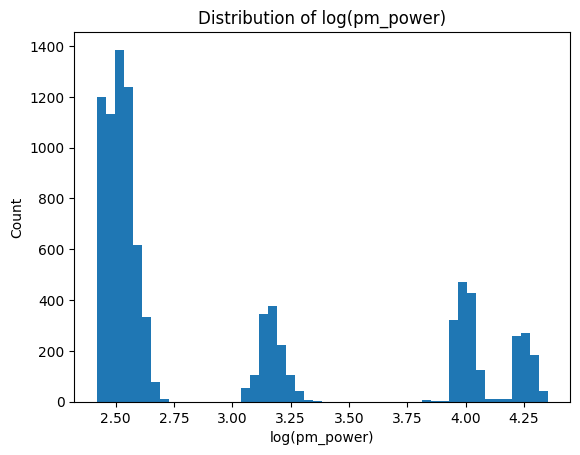

In [35]:
import numpy as np
import matplotlib.pyplot as plt

log_power = np.log1p(df["pm_power"])

plt.figure()
plt.hist(log_power, bins=50)
plt.title("Distribution of log(pm_power)")
plt.xlabel("log(pm_power)")
plt.ylabel("Count")
plt.show()



## Baseline Results on UL Dataset (B→B)

The baseline DNN model was first trained and evaluated on the UL dataset using the same feature set (`airtime`, `selected_mcs`) and network architecture as in the O-RAN baseline experiments. This was done to ensure a fair and controlled comparison between the two datasets.

The training and validation losses decrease smoothly during training and remain close to each other, indicating that the model is able to converge stably and does not suffer from overfitting. However, the absolute error values remain high throughout training, and the final test performance is poor, with a mean relative error (MRE) of approximately 90%.

This result suggests that the poor performance is not caused by optimisation issues or model instability, but rather by the limited predictive power of the selected input features for the UL dataset.

### Analysis of UL Power Characteristics

Further analysis of the UL dataset reveals a highly multi-modal distribution of power consumption. In contrast to the O-RAN dataset, where power values are concentrated within a narrow range, the UL dataset exhibits several distinct power levels, spanning from low-power states (~10 W) to high-power states (>60 W).

The UL dataset exhibits a multi-modal power distribution, indicating the presence of multiple underlying system states. As airtime alone cannot distinguish between these states, baseline regression models fail to capture the power dynamics, resulting in high prediction error.

Scatter plots of power consumption against airtime show that, for a fixed airtime value, the observed power consumption can vary significantly across multiple operating regimes. This indicates the presence of multiple underlying system states (e.g., different platform configurations, background load conditions, or processing modes) that are not explicitly captured by the available features.

As a result, the mapping from (`airtime`, `selected_mcs`) to power consumption in the UL dataset is inherently ambiguous. Under such conditions, a regression model trained from random initialisation is unable to identify a single consistent relationship, leading to large prediction errors despite stable convergence.

### Motivation for Transfer Learning

Although the baseline model performs poorly on the UL dataset, this does not imply that the UL data itself is unsuitable for modelling. Instead, it highlights that the UL task is more challenging and that the available features alone are insufficient to fully characterise the power consumption behaviour.

In contrast, the baseline results on the O-RAN dataset demonstrate that the same feature set can effectively predict power consumption in a related but more controlled system. This suggests that the model trained on O-RAN data has already learned physically meaningful representations of how wireless transmission parameters influence system power consumption.

Transfer learning therefore provides a natural next step. By initialising the UL model with parameters learned from the O-RAN dataset, the model is no longer trained from scratch, but instead starts from a representation that encodes general power–parameter relationships observed in a related domain. This prior knowledge can help guide learning on the UL dataset, potentially reducing prediction error even when the target data exhibits multiple operating regimes and limited feature informativeness.

Based on these observations, the next stage of this work investigates whether transfer learning from O-RAN to UL can improve power prediction performance compared to training solely on the UL dataset.
